# Table of Contents
 <p><div class="lev1"><a href="#Data-pre-processing"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data pre-processing</a></div><div class="lev2"><a href="#Data-import"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data import</a></div><div class="lev2"><a href="#Remove-questionable-data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Remove questionable data</a></div><div class="lev2"><a href="#Create-X-and-Y-arrays-for-each-school-district"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create X and Y arrays for each school district</a></div><div class="lev2"><a href="#Boundaries"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Boundaries</a></div><div class="lev1"><a href="#Model-with-fied-hyperparameters"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model with fied hyperparameters</a></div><div class="lev2"><a href="#Fit-GPs-for-each-district"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit GPs for each district</a></div><div class="lev2"><a href="#2GP-posterior"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2GP posterior</a></div><div class="lev2"><a href="#Inverse-Variance"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inverse-Variance</a></div><div class="lev1"><a href="#Incorporating-covariates"><span class="toc-item-num">3&nbsp;&nbsp;</span>Incorporating covariates</a></div><div class="lev1"><a href="#Hyperparameters"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameters</a></div>

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data pre-processing
## Data import

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar, 
    :PersonalProperty, 
    :PartialInterest])

In [3]:
print(names(Tucson_sales))

[:x,:ADDRESS,:ADPARCEL_,:ADPARCEL_I,:ADR_ID,:AD_STREET,:AD_SUFFIX,:ANGLE,:AREA,:CITY_ID,:CODE,:DATE_ENTER,:LAT,:LON,:PERIMETER,:POLYGONID,:SCALE,:SOURCE,:STATUS,:STREET,:STREET_DIR,:STREET_IDX,:STREET_NAM,:STREET_NO,:SUFFIX_DIR,:TILE_NAME,:X_HPGN,:Y_HPGN,:ZIPCITY,:ZIPCODE,:geometry,:SequenceNum,:SaleDate,:SalePrice,:PropertyType,:IntendedUse,:Deed,:Financing,:ValidationDescription,:BuyerSellerRelated,:Solar,:PersonalProperty,:PartialInterest,:RecordingDate,:SchDistr,:X_PRJ,:Y_PRJ]

## Remove questionable data

In [4]:
levels(Tucson_sales[:,:ValidationDescription])

23-element Array{UTF8String,1}:
 "Buyer/Seller are related parties or corporate entities" 
 "Buyer/Seller has an Out-Of-State Address"               
 "Buyer/Seller is a Non-Profit institution"               
 "Correction of previously recorded deed"                 
 "Developers discount/value by Land manual"               
 "Good Sale"                                              
 "Improvements not yet on assessment roll"                
 "Internet sale"                                          
 "More than five (5) parcels being sold"                  
 "Name/Address of Buyer or Seller is missing"             
 "Property altered since date of sale"                    
 "Property type/use code are not consistent"              
 "Sale by subsidiary corp. to parent corp."               
 "Sale includes quantifiable Personal Property > 5%"      
 "Sale includes unquantifiable Personal Property > 5%"    
 "Sale of partial interest"                               
 "Sale price missing"   

In [5]:
levels(Tucson_sales[:,:PropertyType])

8-element Array{UTF8String,1}:
 "2-4 Plex"             
 "Apartment Building"   
 "Commercial/Industrial"
 "Condo/Townhouse"      
 "Mobile Home"          
 "Other"                
 "Single Family"        
 "Vacant Land"          

In [6]:
believable = (
      (Tucson_sales[:,:BuyerSellerRelated].=="No") 
    & (Tucson_sales[:,:PartialInterest].=="No")
    & [x in ("2-4 Plex", "Condo/Townhouse", "Single Family") # debatable choice?
            for x in Tucson_sales[:,:PropertyType]]
    & (Tucson_sales[:,:ValidationDescription].=="Good Sale")
    
)
believable[isna(believable)]=false
believable=believable.refs.==2

8759-element BitArray{1}:
 false
  true
 false
  true
  true
  true
  true
  true
  true
  true
  true
  true
 false
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
  true
 false

## Create X and Y arrays for each school district

In [7]:
Y_dict=Dict{UTF8String, Vector{Float64}}()
X_dict=Dict{UTF8String, Array{Float64,2}}()

Dict{UTF8String,Array{Float64,2}} with 0 entries

In [8]:
schdistrs = unique(Tucson_sales[:,:SchDistr])

6-element DataArrays.DataArray{UTF8String,1}:
 "Flowing Wells Unified District"
 "Tucson Unified District"       
 "Amphitheater Unified District" 
 "Sunnyside Unified District"    
 "Vail Unified District"         
 "Tanque Verde Unified District" 

In [9]:
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[(Tucson_sales[:,:SchDistr] .== name) & believable,:SalePrice])
    X_dict[name] = Tucson_sales[(Tucson_sales[:,:SchDistr] .== name) & believable,[:X_PRJ, :Y_PRJ]]'
end

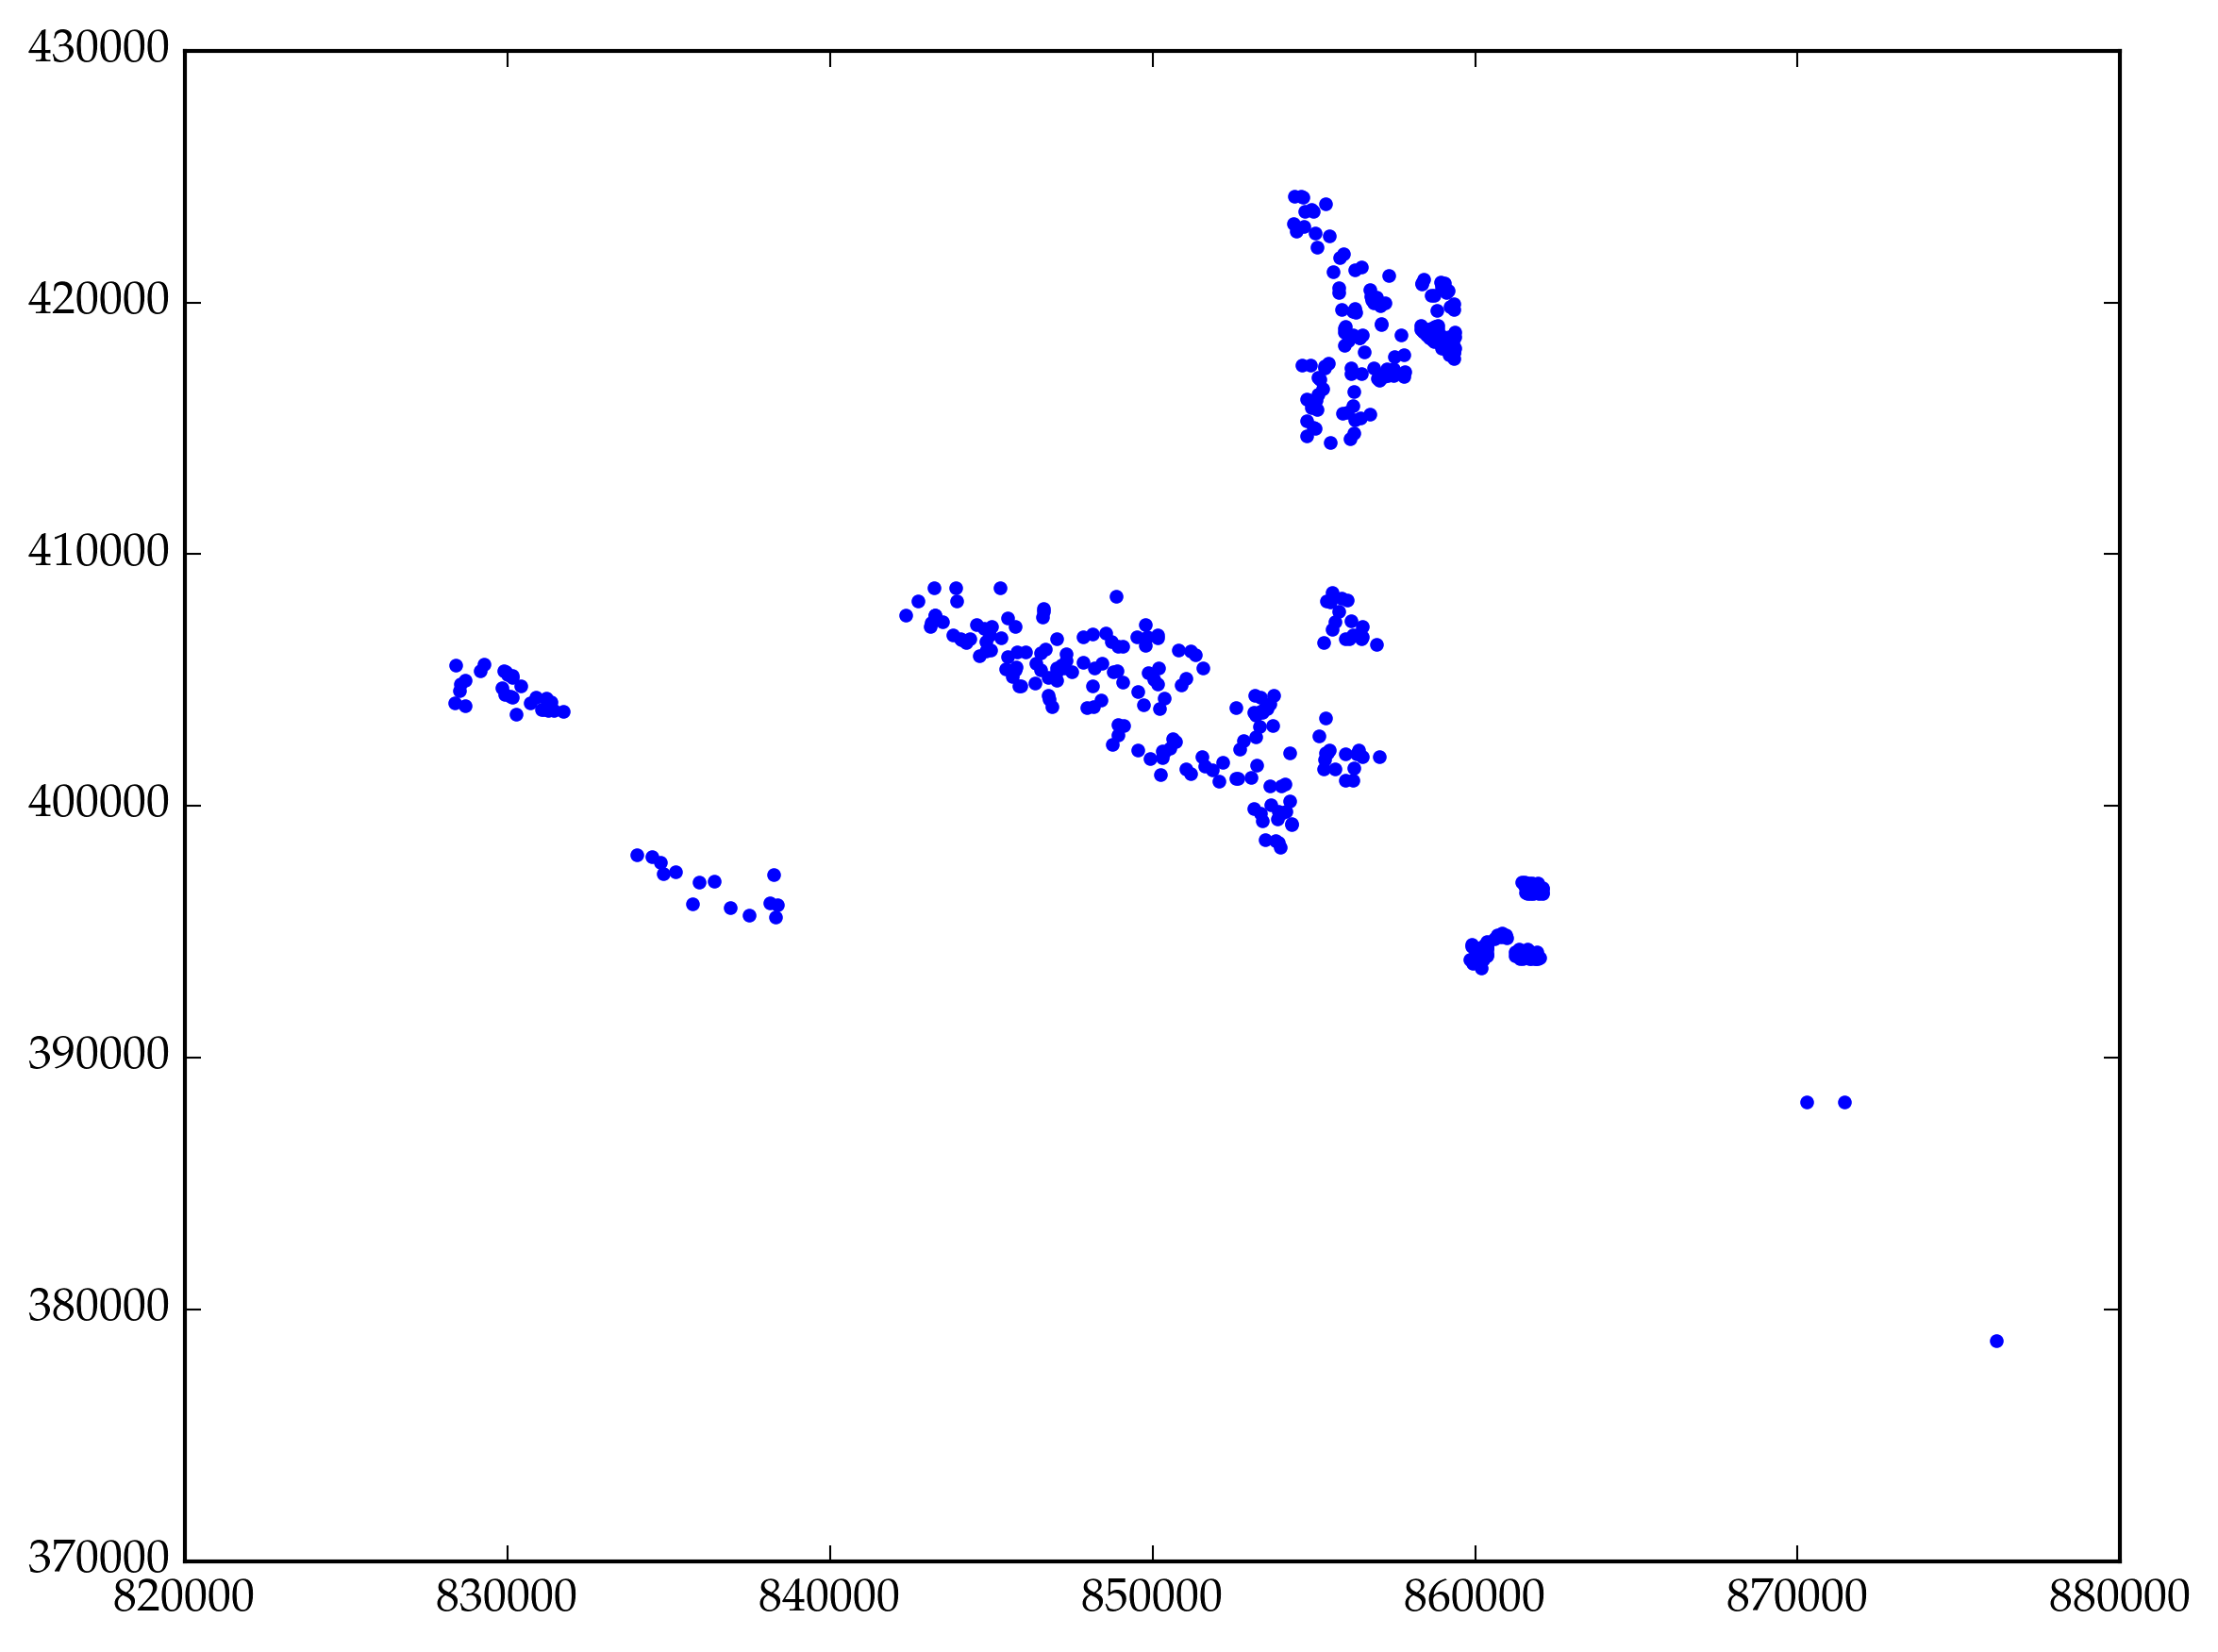

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31db52410>

In [10]:
plt.plot(X_dict["Vail Unified District"][:,1], X_dict["Vail Unified District"][:,2], ".")

In [11]:
std(X_dict["Vail Unified District"],1)

1x2 Array{Float64,2}:
 8626.72  9070.73

In [12]:
std(Y_dict["Vail Unified District"],1)

1-element Array{Float64,1}:
 0.292352

## Boundaries

In [13]:
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
;

In [14]:
sentinels_json.features[1].geometry

GeoJSON.MultiPoint([[787778.4481149958,455984.5341643696],[787751.0865443938,456397.6698585751],[787749.5781172435,456812.8333104904],[787745.7609360296,457227.9974193714],[787739.4065910273,457643.1370777555],[787735.2310601263,458058.3067060452],[787733.2446003554,458473.48214729567],[787730.4144609333,458888.6513425225],[787723.2484005521,459303.7800677075],[787714.9517681954,459718.8883934101]  …  [774413.2665882893,483965.60216168914],[774419.9755080368,484380.7132384444],[774408.9251022419,484795.6946818855],[774394.2752866163,485210.62389735965],[774379.9567833405,485625.5680679589],[774365.642725977,486040.51255899627],[774351.1690942488,486455.45150267304],[774329.0811134004,486870.0242033865],[774266.8216665802,487280.4599729624],[774095.8863404287,487562.1370055481]],#undef,#undef)

In [15]:
sentinels_json.features[1].properties

Dict{UTF8String,Any} with 2 entries:
  "SchoolDistrict2" => "Flowing Wells Unified District"
  "SchoolDistrict1" => "Amphitheater Unified District"

In [16]:
sentinels=Dict{Tuple{UTF8String,UTF8String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

In [17]:
sentinels

Dict{Tuple{UTF8String,UTF8String},GeoJSON.MultiPoint} with 20 entries:
  ("Vail Unified District… => GeoJSON.MultiPoint([[827838.9234102826,424598.640…
  ("Sunnyside Unified Dis… => GeoJSON.MultiPoint([[732616.9915119059,402400.328…
  ("Flowing Wells Unified… => GeoJSON.MultiPoint([[787778.4481149958,455984.534…
  ("Vail Unified District… => GeoJSON.MultiPoint([[827978.8141461494,376356.671…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[800840.1244605089,468987.397…
  ("Tanque Verde Unified … => GeoJSON.MultiPoint([[891423.8112493764,424978.648…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[853566.3010435958,477957.228…
  ("Sunnyside Unified Dis… => GeoJSON.MultiPoint([[716932.1348773959,391746.233…
  ("Tanque Verde Unified … => GeoJSON.MultiPoint([[853566.3010435958,477957.228…
  ("Vail Unified District… => GeoJSON.MultiPoint([[891423.8112493764,424978.648…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[787778.4481149958,455984.534…
  ("Amphitheater Unified … => GeoJSON.

# Model with fied hyperparameters
## Fit GPs for each district

Fitting the hyperparameters is a whole other difficult issue. Let's skip ahead, plug in some arbitrary values, and come back to it later.

In [38]:
GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    GP_dict[name] = fit
end

In [39]:
delete!(GP_dict, "Tanque Verde Unified District")

Dict{UTF8String,GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel}} with 5 entries:
  "Flowing Wells Unified … => GP object:…
  "Amphitheater Unified D… => GP object:…
  "Sunnyside Unified Dist… => GP object:…
  "Vail Unified District"  => GP object:…
  "Tucson Unified Distric… => GP object:…

## 2GP posterior

In [72]:
distr1 = "Amphitheater Unified District"
distr2 = "Tucson Unified District"

"Tucson Unified District"

In [73]:
X◫ = hcat(sentinels[distr1,distr2].coordinates...)

2x100 Array{Float64,2}:
 8.0084e5   8.00848e5  8.0085e5   …  7.88304e5  7.88041e5  7.87778e5
 4.68987e5  4.68725e5  4.68462e5     4.55982e5  4.55983e5  4.55985e5

In [74]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [75]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

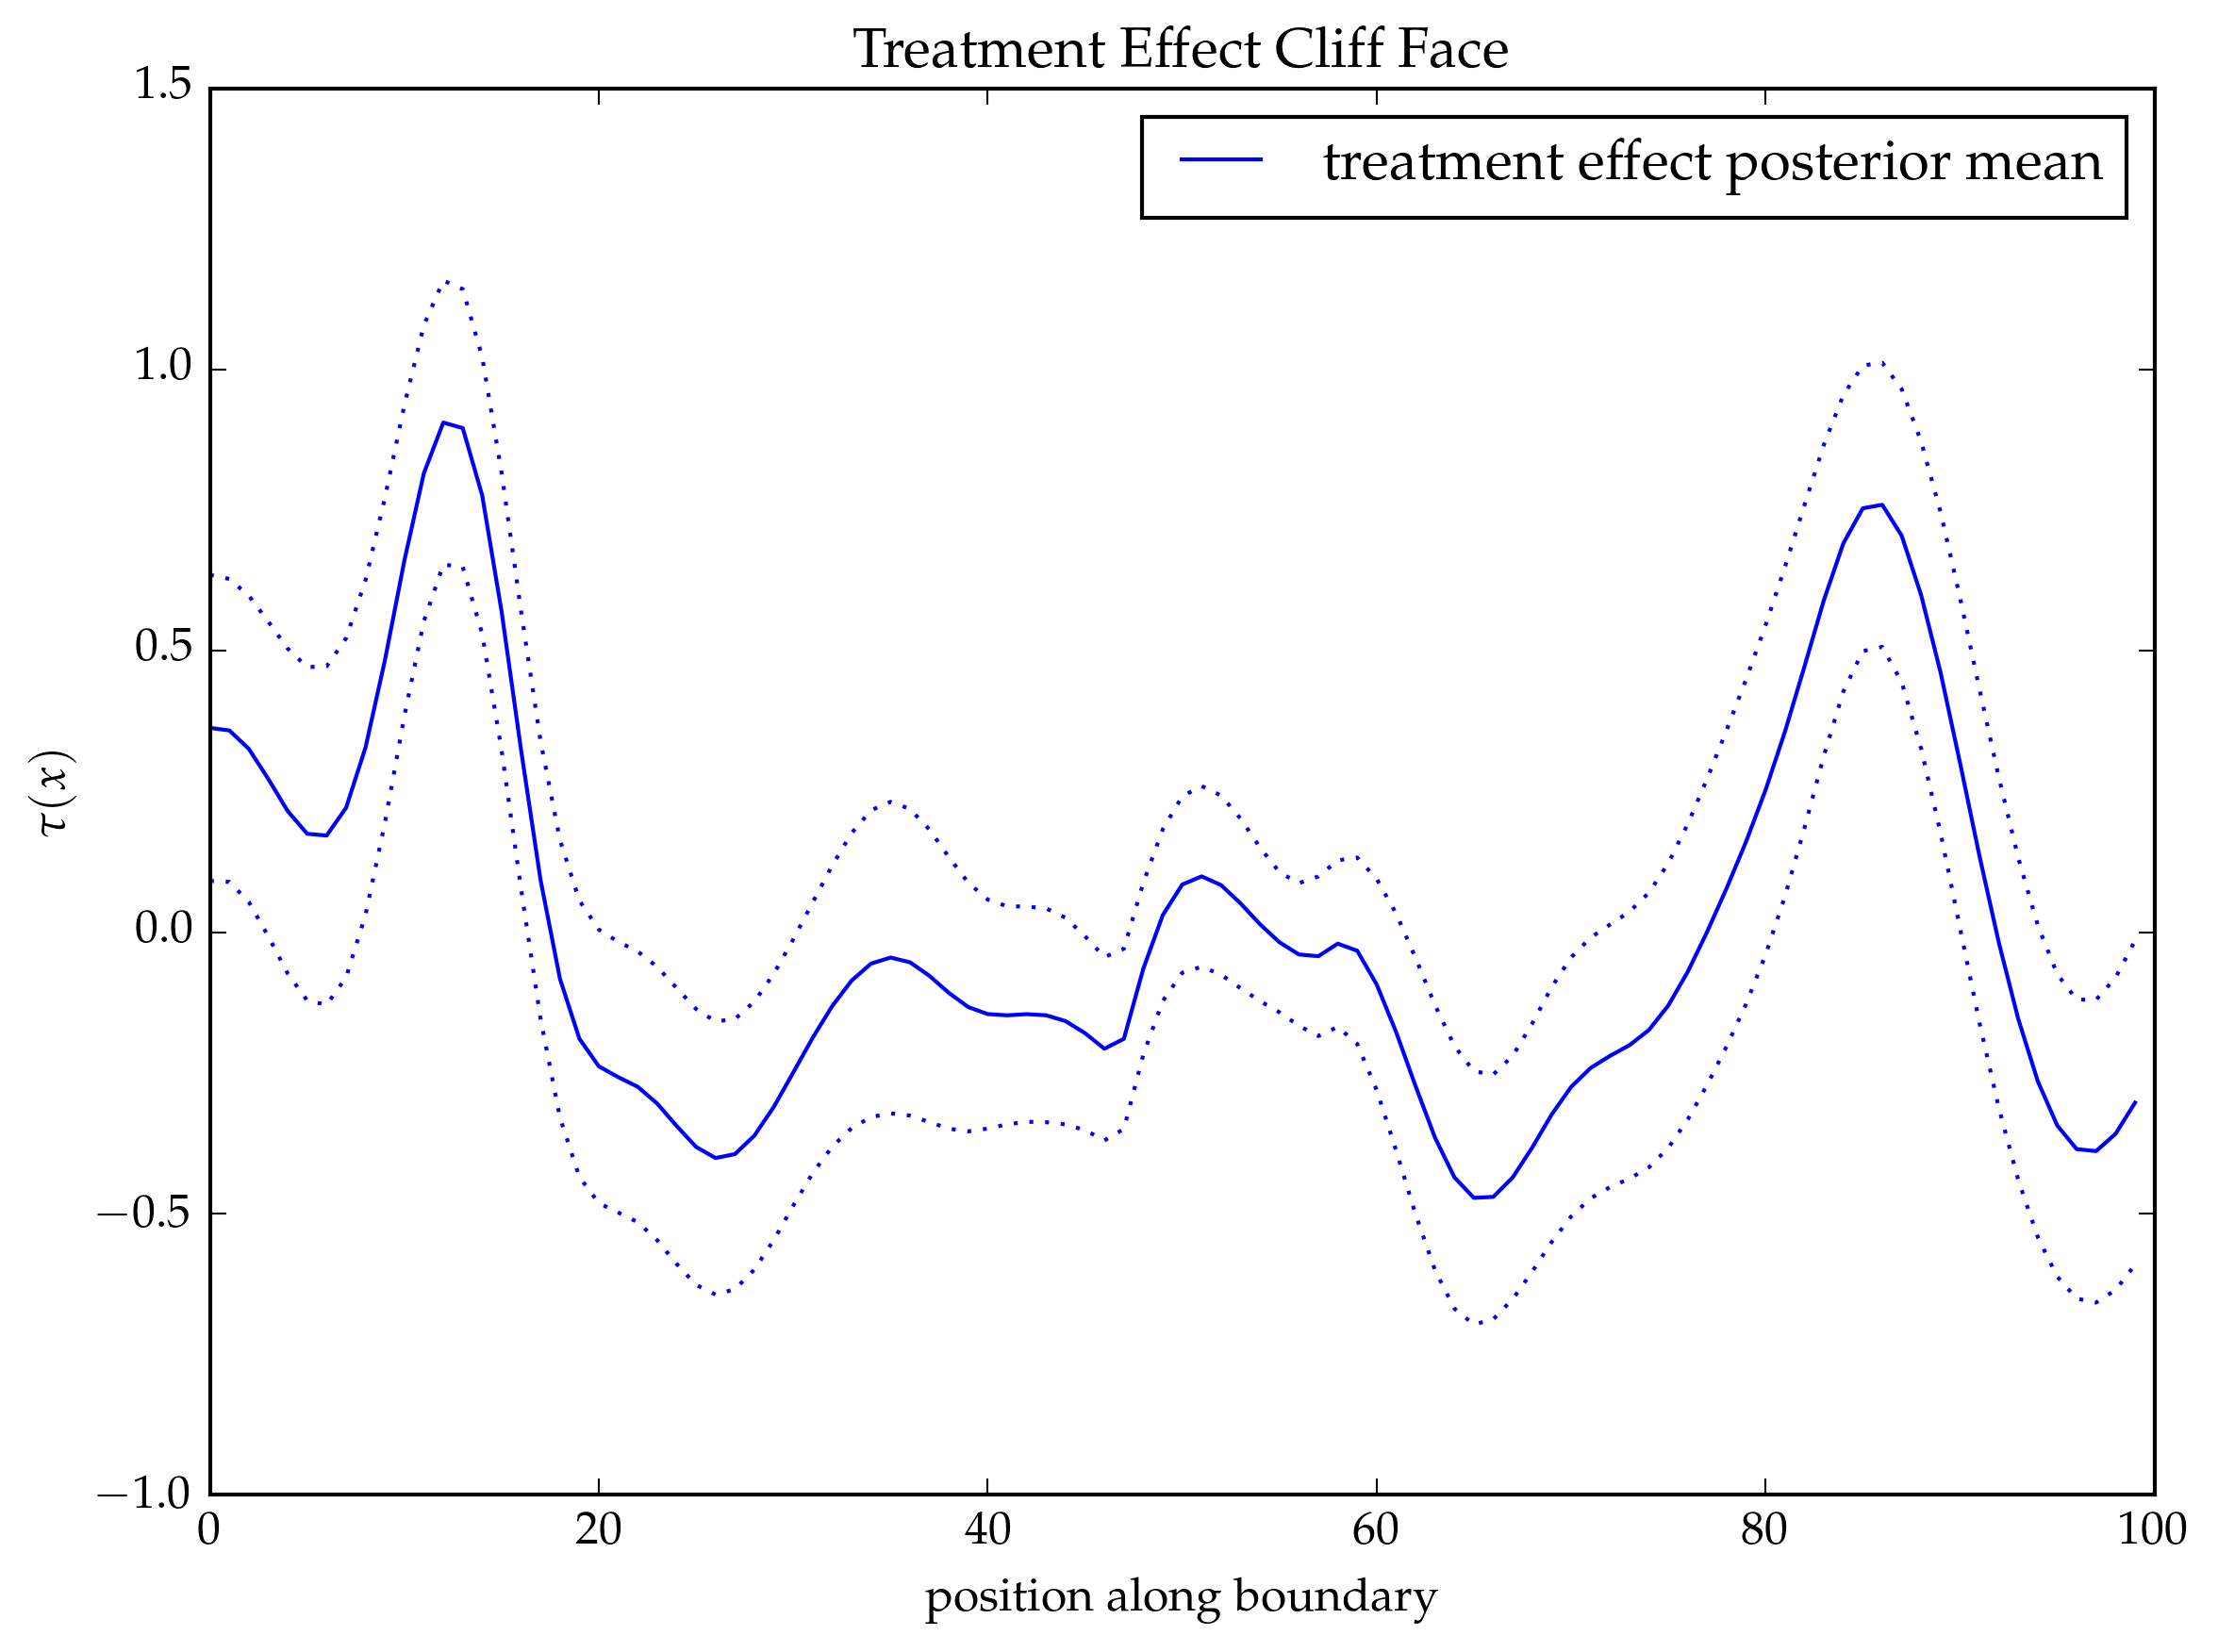

In [76]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
# plt.axhline(y=0, color="black")
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

## Inverse-Variance

In [77]:
n◫ = size(X◫)[2]

100

In [78]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=-0.040773471082906, σ=0.05480492421525723)

# Incorporating covariates

# Hyperparameters

Now the difficult part. We need to fit the GP hyperparameters to the data.

In [27]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel},1}

In [28]:
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gps::MultiGP`: Vector of Gaussian Processes to fit with the same parameters
* `noise::Bool`: Noise hyperparameters should be optimized
* `mean::Bool`: Mean function hyperparameters should be optimized
* `kern::Bool`: Kernel function hyperparameters should be optimized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function optimize!(mgp::MultiGP; noise::Bool=true, mean::Bool=true, kern::Bool=true, method=ConjugateGradient(), kwargs...)
    function mll(hyp::Vector{Float64})
        mLL = 0.0
        println("mll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll!(gp)
                mLL += gp.mLL
            end
        catch err
            if isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end  
        println("-mLL: ", -mLL)
        return -mLL
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        println("dmll setting parameters: ", hyp)
        for gp in mgp
            GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
            GaussianProcesses.update_mll_and_dmll!(gp; noise=noise, mean=mean, kern=kern)
            grad[:] -= gp.dmLL
        end
    end
    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        mLL = 0.0
        println("mll_and_dmll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll_and_dmll!(gp; noise=noise, mean=mean, kern=kern)
                mLL += gp.mLL
                grad[:] -= gp.dmLL
            end
        catch err
            if isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end
        println("-mLL: ", -mLL)
        return -mLL
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = GaussianProcesses.get_params(mgp[1];  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    println("initial parameters: ", init)
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    print(results)
end

optimize! (generic function with 1 method)

In [40]:
@time hyp_fit=optimize!(collect(values(GP_dict)), 
    noise=true, mean=true, kern=true, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10)

initial parameters: [-2.3025850929940455,11.771065706252383,6.907755278982137,-1.6094379124341003]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-2.3025850929940455,11.771065706252383,6.907755278982137,-1.6094379124341003]
-mLL: 3808.2053567201415
     0     3.808205e+03     8.397628e+03
mll setting parameters: [1677.2229434262254,-406.29197242924073,-503.2230214251048,674.3649938242925]
-mLL: NaN
mll setting parameters: [165.64996775892794,-30.035238107296937,-44.10532239142657,65.98800526123857]
Base.LinAlg.PosDefException(30)
mll setting parameters: [14.492670192198153,7.5904353248974505,1.8064475119412666,5.150306404933167]
-mLL: 61970.0787002941
mll_and_dmll setting parameters: [14.492670192198153,7.5904353248974505,1.8064475119412666,5.150306404933167]
-mLL: 61970.0787002941
mll_and_dmll setting parameters: [10.012522756958308,8.70562173693291,3.1672253340579317,3.3471393406593055]
-mLL: 43955.40915584898
mll_and_dmll setting parameters: [3.8549688319

Not great! I've obtained minimums below 1000, so we're quite far away from a global minimum. Now let's reset the GPs and optimize again with the LBFGS method instead of ConjugateGradient, to see if we get the same result, and which is faster.

In [41]:
GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    GP_dict[name] = fit
end

In [42]:
delete!(GP_dict, "Tanque Verde Unified District")

Dict{UTF8String,GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel}} with 5 entries:
  "Flowing Wells Unified … => GP object:…
  "Amphitheater Unified D… => GP object:…
  "Sunnyside Unified Dist… => GP object:…
  "Vail Unified District"  => GP object:…
  "Tucson Unified Distric… => GP object:…

In [43]:
@time hyp_fit=optimize!(collect(values(GP_dict)), 
    noise=true, mean=true, kern=true, 
    method=LBFGS(), 
    show_trace=true, iterations=10)

initial parameters: [-2.3025850929940455,11.771065706252383,6.907755278982137,-1.6094379124341003]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-2.3025850929940455,11.771065706252383,6.907755278982137,-1.6094379124341003]
-mLL: 3808.2053567201415
     0     3.808205e+03     8.397628e+03
mll_and_dmll setting parameters: [8395.325057503103,-2078.544124971213,-2543.7461282414524,3378.2627207711985]
-mLL: NaN
mll_and_dmll setting parameters: [837.4601791666157,-197.26045336149417,-248.15763307306133,336.3777779559292]
-mLL: NaN
mll_and_dmll setting parameters: [81.67369133296694,-9.132086200522277,-18.598783556222216,32.18928367440223]
Base.LinAlg.PosDefException(30)
mll_and_dmll setting parameters: [6.095042549602054,9.680750515574918,4.357101395461702,1.7704342462495333]
-mLL: 28203.62517218084
mll_and_dmll setting parameters: [3.8551903937518106,10.238288571024826,5.037423010444009,0.8689398881613506]
-mLL: 19204.70620684884
mll_and_dmll setting parameters:

In [71]:
k=next(values(GP_dict),1)[1].k
k.σ2, √(k.ℓ2)

(0.047928665453216335,934.043869501199)

Better, but still very far off the global optimum, and the parameter values obtained aren't particularly convincing.

In [79]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [80]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

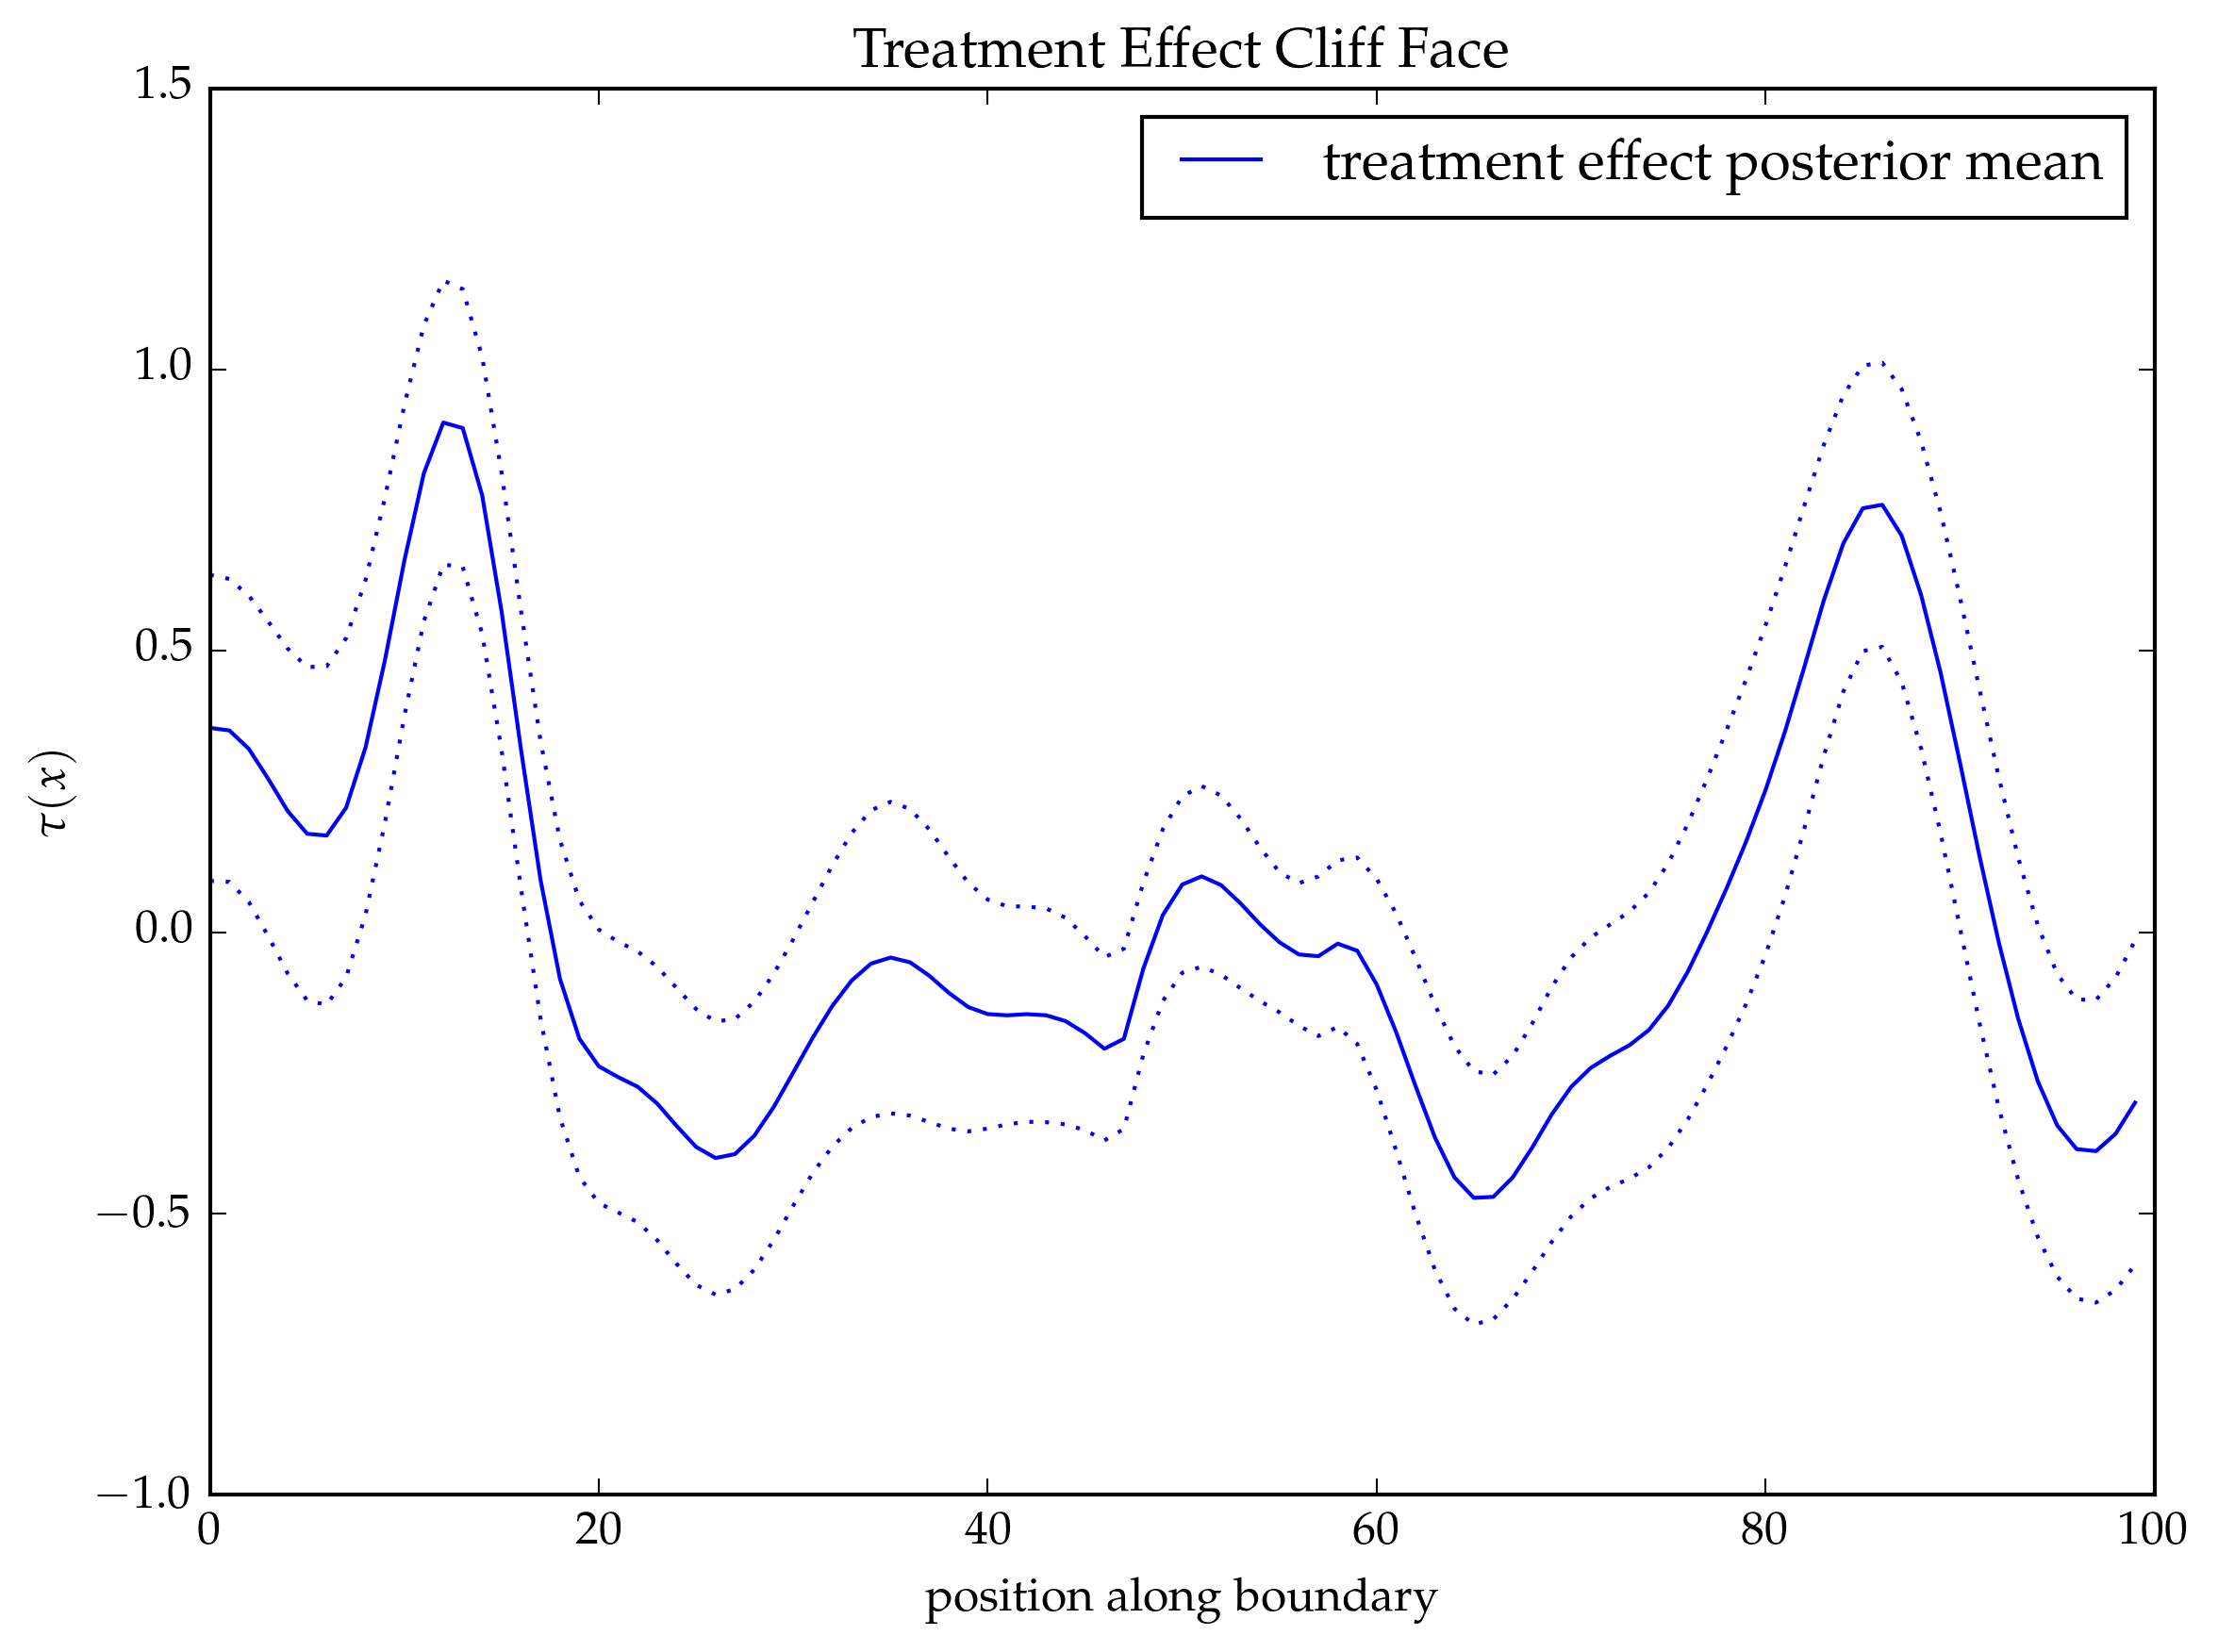

In [81]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
# plt.axhline(y=0, color="black")
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [82]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=-0.040773471082906, σ=0.05480492421525723)

This new value of the hyperparameters changes the inverse-variance-weighted mean drastically. This shows that the choice of hyperparameters is crucial here, and needs to be thought about very carefully.